# The Power of Multitask Learning

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, MultiTaskLassoCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

## Data

In [12]:
data = pd.read_csv("../data/nyc-rides.csv", parse_dates=['ds'], dtype={'task':'object'})
print(data.shape)
data.head()

(1462, 3)


,ds,task,y
0,2016-01-01,1,150774
1,2016-01-01,2,194263
2,2016-01-02,1,141877
3,2016-01-02,2,170954
4,2016-01-03,1,141223


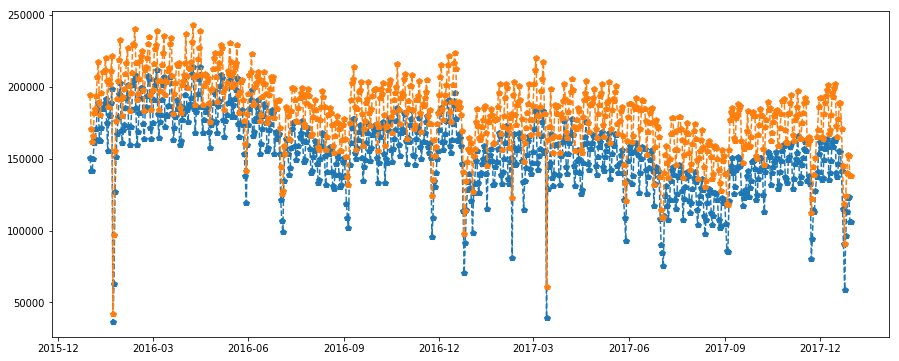

In [123]:
fig, ax = plt.subplots(figsize = (15, 6))
for t in data.task.unique():
    t_data = data.loc[data.task == t].copy()
    plt.plot_date(t_data.ds, t_data.y, 'p--')

## Data Transformation

We utilize the Fourier series to model our data. For details, see:
1. [Sean J. Taylor, Benjamin Letham (2018) Forecasting at scale. The American Statistician 72(1):37-45](https://peerj.com/preprints/3190.pdf).
1. Harvey, A. C. & Shephard, N. (1993), Structural time series models, in G. Maddala, C. Rao
& H. Vinod, eds, ‘Handbook of Statistics’, Vol. 11, Elsevier, chapter 10, pp. 261–302.

In [567]:
dates_range = data['ds'].sort_values().drop_duplicates()
epoch = pd.to_datetime('2015-01-01')
t = (dates_range - epoch).dt.days

periods = [7, 365.25]
orders = 200
X_seasonal =  np.column_stack([
                               fun((2.0 * (i + 1) * np.pi * t / p))
                               for i in range(orders)
                               for p in periods
                               for fun in (np.sin, np.cos)
                               ])
X_cp = t/t.max()

In [568]:
X = np.column_stack([X_seasonal, X_cp])

In [569]:
Y_df = data.pivot_table(index = 'ds', columns='task', values='y')
Y = Y_df.values
# normalize Y
Y = Y / Y.max(0)

In [570]:
train_size = 600

In [571]:
m = MultiTaskLassoCV().fit(X[:train_size,], Y[:train_size,])

In [572]:
Y_pred = m.predict(X)

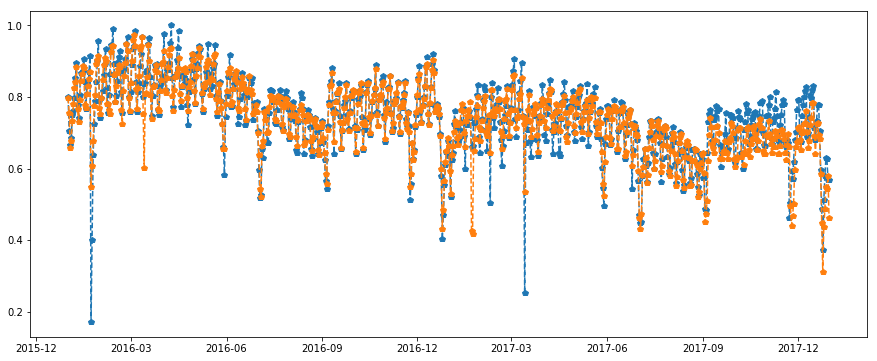

In [573]:
fig, ax = plt.subplots(figsize = (15, 6))
idx = 1
plt.plot_date(Y_df.index, Y[:,idx], 'p--')
plt.plot_date(Y_df.index, Y_pred[:,idx], 'p--')

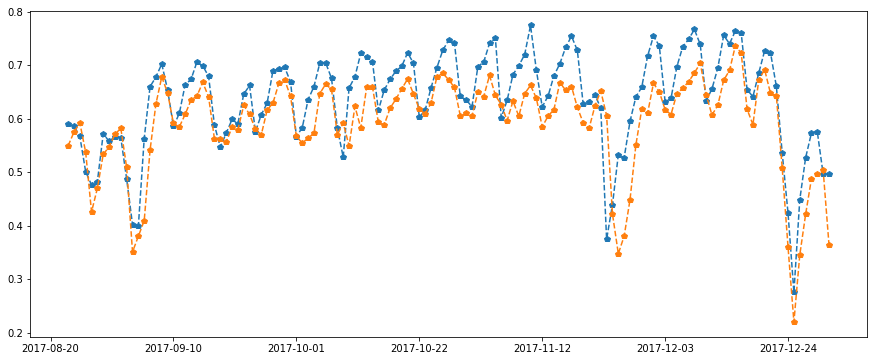

In [574]:
fig, ax = plt.subplots(figsize = (15, 6))
idx = 0
plt.plot_date(Y_df.index[train_size:], Y[train_size:,idx], 'p--')
plt.plot_date(Y_df.index[train_size:], Y_pred[train_size:,idx], 'p--')

In [575]:
mean_squared_error(Y[train_size:,], Y_pred[train_size:,])

0.003919570817919174

In [576]:
class stlLasso():
    """
    Simple implementation of STL Lasso
    """
    def __init__(self, **kwargs):
        self.params = kwargs
        self.models = None
        
    def fit(self, X, Y):
        self.models = [LassoCV(**self.params).fit(X, Y[:,i]) for i in range(Y.shape[1])]
    
    def predict(self, X):
        return np.column_stack([model.predict(X) for model in self.models])
        
#     def get_params(self):
#         print(self.params)

In [577]:
sl = stlLasso() # fit_intercept = False

In [578]:
sl.fit(X[:train_size,], Y[:train_size,])

In [579]:
Y_pred_stl = sl.predict(X)

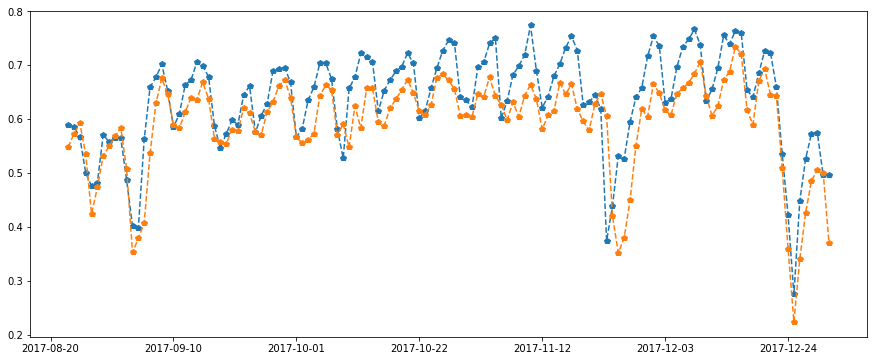

In [580]:
fig, ax = plt.subplots(figsize = (15, 6))
idx = 0
plt.plot_date(Y_df.index[train_size:], Y[train_size:,idx], 'p--')
plt.plot_date(Y_df.index[train_size:], Y_pred_stl[train_size:,idx], 'p--')

In [581]:
mean_squared_error(Y[train_size:,], Y_pred_stl[train_size:,]) /\
    mean_squared_error(Y[train_size:,], Y_pred[train_size:,])

0.9831250961433845

In [582]:
mean_squared_error(Y[train_size:,], Y_pred[train_size:,])

0.003919570817919174

In [583]:
mean_squared_error(Y[train_size:,], Y_pred_stl[train_size:,])

0.003853428437207592

In [ ]:
LassoCV()

# test

In [1]:
# from google.cloud import bigquery
# client = bigquery.Client()

# query = (
#     "SELECT name FROM `bigquery-public-data.usa_names.usa_1910_2013` "
#     'WHERE state = "TX" '
#     "LIMIT 100"
# )
# query_job = client.query(
#     query,
#     # Location must match that of the dataset(s) referenced in the query.
#     location="US",
# )  # API request - starts the query

# for row in query_job:  # API request - fetches results
#     # Row values can be accessed by field name or index
#     assert row[0] == row.name == row["name"]
#     print(row)

In [3]:
import bq_helper
from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
chicago_taxi = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                        dataset_name="chicago_taxi_trips")

In [4]:
bq_assistant = BigQueryHelper("bigquery-public-data", "chicago_taxi_trips")
bq_assistant.head("taxi_trips", num_rows=3)

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,93813c91532a5bc624ef309a01563ee564f72345,f7753ec5feb07452f927f7e42c1808f1e6c34ee6a48e8d...,2015-11-19 05:45:00+00:00,2015-11-19 05:45:00+00:00,0,0.0,None,None,None,None,...,0.0,465.0,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
1,938b26c7156a10be12c67d9dbd75ff6aa8271f6e,53d18a0c85f3bf6b56ae7d2da5a5f3885d15ac664d5a34...,2014-06-04 09:45:00+00:00,2014-06-04 09:45:00+00:00,0,0.0,None,None,None,None,...,0.0,4200.0,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None
2,939965418af3022fb1ec098c2f4d9c69c9d6627e,68e1a2ea570e86d7ca0402907273138fa5aede37ae81ee...,2016-01-21 07:45:00+00:00,2016-01-21 07:45:00+00:00,0,0.0,None,None,None,None,...,0.0,775.0,Cash,Chicago Elite Cab Corp. (Chicago Carriag,None,None,None,None,None,None


In [67]:
query1 = \
"""
SELECT
  EXTRACT(date FROM trip_start_timestamp) AS ds,
  company as task,
  --FORMAT('%3.2f', MAX(fare)) AS maximum_fare,
  --FORMAT('%3.2f', MIN(fare)) AS minimum_fare,
  --FORMAT('%3.2f', AVG(fare)) AS avg_fare,
  --FORMAT('%3.2f', STDDEV(fare)) AS std_dev_fare,
  COUNT(1) AS y
FROM
  `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE 1=1
and company in ('Blue Ribbon Taxi Association Inc.', 
  --'Taxi Affiliation Services', 
  'Choice Taxi Association', 
  --'Northwest Management LLC', 
  'Dispatch Taxi Affiliation')
and EXTRACT(date FROM trip_start_timestamp) <= '2017-07-26'
GROUP BY
  1,2
ORDER BY
  2,1        
  """
chicago_data = chicago_taxi.query_to_pandas_safe(query1, max_gb_scanned=10)
chicago_data.ds = pd.to_datetime(chicago_data.ds)
chicago_data.head(10)

,ds,task,y
0,2013-01-01,Blue Ribbon Taxi Association Inc.,4623
1,2013-01-02,Blue Ribbon Taxi Association Inc.,2632
2,2013-01-03,Blue Ribbon Taxi Association Inc.,2806
3,2013-01-04,Blue Ribbon Taxi Association Inc.,3463
4,2013-01-05,Blue Ribbon Taxi Association Inc.,3558
5,2013-01-06,Blue Ribbon Taxi Association Inc.,3011
6,2013-01-07,Blue Ribbon Taxi Association Inc.,2851
7,2013-01-08,Blue Ribbon Taxi Association Inc.,2829
8,2013-01-09,Blue Ribbon Taxi Association Inc.,2862
9,2013-01-10,Blue Ribbon Taxi Association Inc.,3320


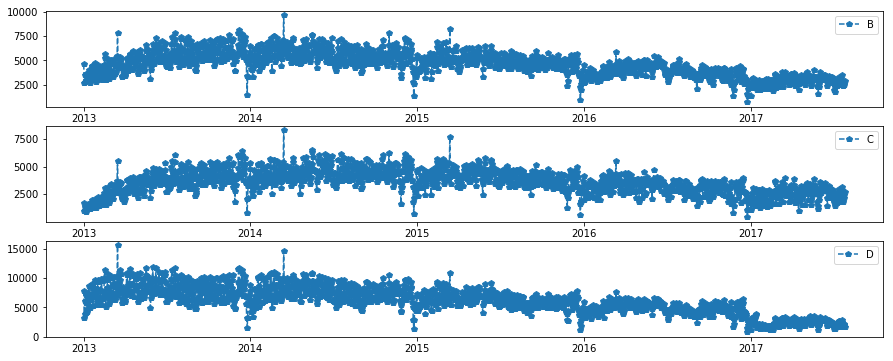

In [68]:
fig, ax = plt.subplots(3, 1, figsize = (15, 6))
for i, t in enumerate(chicago_data.task.unique()):
    t_data = chicago_data.loc[chicago_data.task == t].copy()
    ax[i].plot_date(t_data.ds, t_data.y, 'p--')
    ax[i].legend(t)

In [123]:
train_size = 1500

In [184]:
dates_range = chicago_data['ds'].sort_values().drop_duplicates()
epoch = pd.to_datetime('2012-01-01')
t = (dates_range - epoch).dt.days

periods = [7, 365.25]
orders = 20
X_seasonal =  np.column_stack([
                               fun((2.0 * (i + 1) * np.pi * t / p))
                               for i in range(orders)
                               for p in periods
                               for fun in (np.sin, np.cos)
                               ])
# allow for trend change points
n_changepoints = 12 * 3
# cp = [((t.shape[0] - (t.shape[0] // n_changepoints)) // n_changepoints) * (x+1) for x in range(n_changepoints)]
cp = [(train_size // n_changepoints) * (x) for x in range(n_changepoints)]
X_cp = np.zeros((t.shape[0], n_changepoints))
t_scale = t / t.max()
for i, cpoint in enumerate(cp):
    X_cp[cpoint:, i] = t_scale[cpoint:]
#X_cp = t / t.max()

In [185]:
X = np.column_stack([X_seasonal, X_cp])

In [186]:
Y_df = chicago_data.pivot_table(index = 'ds', columns='task', values='y')
Y = Y_df.values
Y = np.log(Y)
# normalize Y
Y = Y / Y.max(0)

In [187]:
m = MultiTaskLassoCV().fit(X[:train_size,], Y[:train_size,])

In [188]:
Y_pred = m.predict(X)

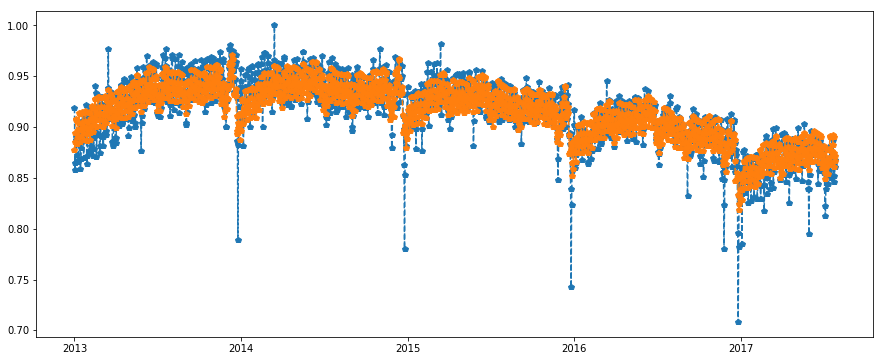

In [189]:
fig, ax = plt.subplots(figsize = (15, 6))
idx = 0
plt.plot_date(Y_df.index, Y[:,idx], 'p--')
plt.plot_date(Y_df.index, Y_pred[:,idx], 'p--')

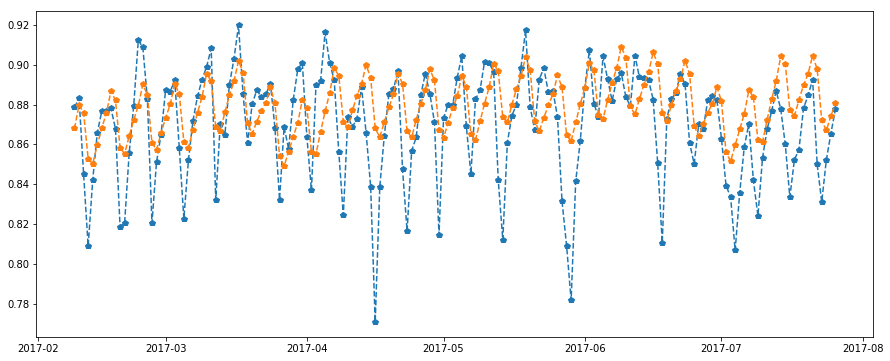

In [210]:
fig, ax = plt.subplots(figsize = (15, 6))
idx = 1
plt.plot_date(Y_df.index[train_size:], Y[train_size:,idx], 'p--')
plt.plot_date(Y_df.index[train_size:], Y_pred[train_size:,idx], 'p--')

In [191]:
mean_squared_error(Y[train_size:,], Y_pred[train_size:,])

0.0006406674501998234

In [192]:
class stlLasso():
    """
    Simple implementation of STL Lasso
    """
    def __init__(self, **kwargs):
        self.params = kwargs
        self.models = None
        
    def fit(self, X, Y):
        self.models = [LassoCV(**self.params).fit(X, Y[:,i]) for i in range(Y.shape[1])]
    
    def predict(self, X):
        return np.column_stack([model.predict(X) for model in self.models])
        
#     def get_params(self):
#         print(self.params)

In [193]:
sl = stlLasso() # fit_intercept = False

In [194]:
sl.fit(X[:train_size,], Y[:train_size,])

In [195]:
Y_pred_stl = sl.predict(X)

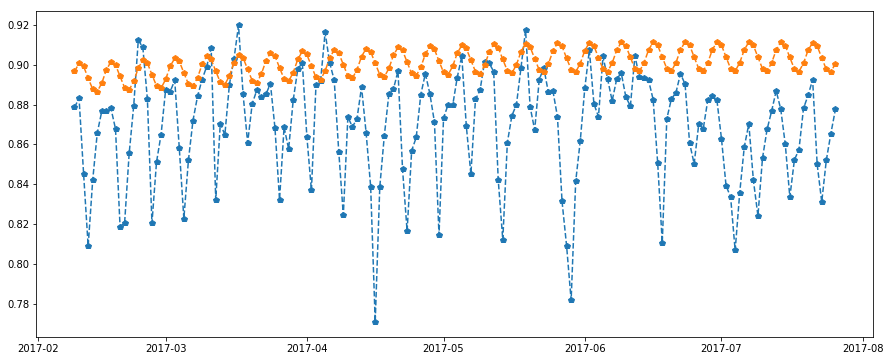

In [202]:
fig, ax = plt.subplots(figsize = (15, 6))
idx = 1
plt.plot_date(Y_df.index[train_size:], Y[train_size:,idx], 'p--')
plt.plot_date(Y_df.index[train_size:], Y_pred_stl[train_size:,idx], 'p--')

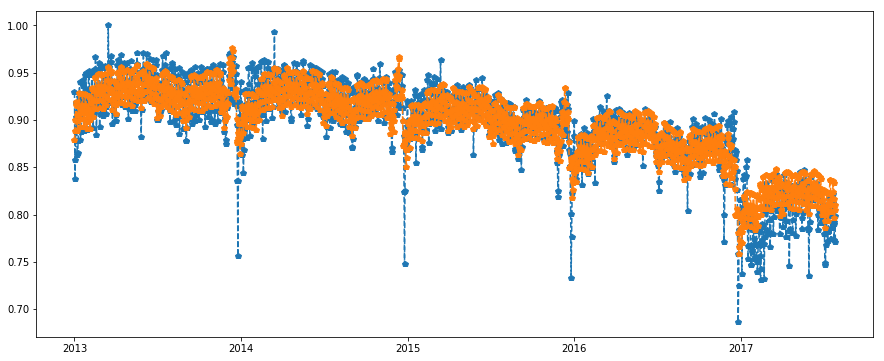

In [209]:
fig, ax = plt.subplots(figsize = (15, 6))
idx = 2
plt.plot_date(Y_df.index, Y[:,idx], 'p--')
plt.plot_date(Y_df.index, Y_pred_stl[:,idx], 'p--')

In [197]:
mean_squared_error(Y[train_size:,], Y_pred_stl[train_size:,]) /\
    mean_squared_error(Y[train_size:,], Y_pred[train_size:,])

1.428364903981673

In [198]:
mean_squared_error(Y[train_size:,], Y_pred[train_size:,])

0.0006406674501998234

In [199]:
mean_squared_error(Y[train_size:,], Y_pred_stl[train_size:,])

0.0009151069009888541

In [16]:
chicago_data.company.value_counts()

Blue Ribbon Taxi Association Inc.           1674
Taxi Affiliation Services                   1674
Choice Taxi Association                     1674
Northwest Management LLC                    1673
Dispatch Taxi Affiliation                   1669
Chicago Medallion Management                1607
Top Cab Affiliation                         1572
KOAM Taxi Association                       1525
T.A.S. - Payment Only                       1336
Chicago Elite Cab Corp. (Chicago Carriag    1112
4623 - 27290 Jay Kim                        1050
1085 - 72312 N and W Cab Co                 1026
6743 - 78771 Luhak Corp                     1015
2092 - 61288 Sbeih company                  1012
3011 - 66308 JBL Cab Inc.                   1006
5074 - 54002 Ahzmi Inc                      1001
Suburban Dispatch LLC                       1001
4053 - 40193 Adwar H. Nikola                 998
3094 - 24059 G.L.B. Cab Co                   992
4197 - 41842 Royal Star                      972
0118 - 42111 Godfrey